Step 0 - import NN libraries 



In [48]:
import numpy as np
import pandas as pd 
import math
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.layers import Conv2D, MaxPool2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import LearningRateScheduler
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from subprocess import check_output
import tensorflow as tf

Step 1 - Load the data 

In [3]:
from keras.datasets import mnist #importing the mnist datset from keras
(x_train, y_train),(x_test, y_test) = mnist.load_data() #splitting the data as test and train
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts))) # displaying the count of unique train.  labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts))) # displaying the count of unique tets labels

11501568/11490434 [==============================] - 0s 0us/step
Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


<BarContainer object of 10 artists>

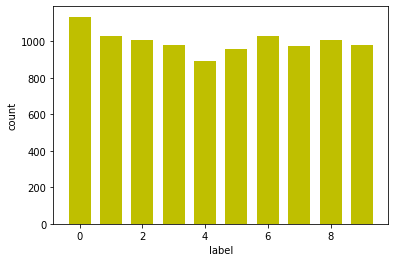

In [4]:
#displaying a bar graph of counts of each label
y_value=np.zeros((1,10))
for i in range (10):
    y_value[0,i-1]= np.count_nonzero(y_test==i)
y_value=y_value.ravel()
x_value=[0,1,2,3,4,5,6,7,8,9]
plt.xlabel('label')
plt.ylabel('count')
plt.bar(x_value,y_value,0.7,color='y')

In [5]:
print('Train Data Dimensions: x=%s, y=%s' % (x_train.shape, y_train.shape)) #printing the dimensions of the train and test data 
print('Test Data Dimensions: x=%s, y=%s' % (x_test.shape, y_test.shape))


Train Data Dimensions: x=(60000, 28, 28), y=(60000,)
Test Data Dimensions: x=(10000, 28, 28), y=(10000,)


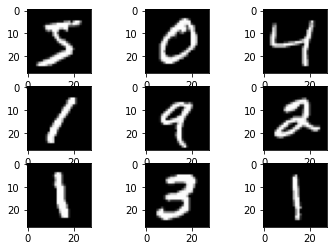

In [6]:
for i in range(9): #displaying 9 images from the train data
	plt.subplot(330 + 1 + i) 	#defining the subplot
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray')) #plotting the raw pixel data
plt.show() #displaying the train data

In [7]:
num_labels = len(np.unique(y_train))
print(num_labels) #printing the number of unique numbers present


10


Step 2 - Data pre-processing


In [8]:
y_train = to_categorical(y_train, num_classes=10) #one hot encoding
y_test = to_categorical(y_test, num_classes=10)

In [9]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [10]:
# resize and normalize
x_train = x_train.astype('float32') / 255
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.astype('float32') / 255
x_test=x_test.reshape(-1,28,28,1)
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [11]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

Building a simple dense network, using sigmoid, relu, and softmax as activation functions

In [12]:
model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0

In [14]:
# Defining the Adams optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [16]:
# Compile the model
model.compile(optimizer = adam , loss = "categorical_crossentropy", metrics=["accuracy"])

In [17]:
#fiiting the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
468/468 [==============================] - 57s 57ms/step - loss: 0.8863 - accuracy: 0.7087 - val_loss: 0.1635 - val_accuracy: 0.9557
Epoch 2/10
468/468 [==============================] - 26s 56ms/step - loss: 0.3505 - accuracy: 0.8928 - val_loss: 0.1017 - val_accuracy: 0.9693
Epoch 3/10
468/468 [==============================] - 27s 57ms/step - loss: 0.2673 - accuracy: 0.9194 - val_loss: 0.0843 - val_accuracy: 0.9736
Epoch 4/10
468/468 [==============================] - 26s 56ms/step - loss: 0.2261 - accuracy: 0.9319 - val_loss: 0.0734 - val_accuracy: 0.9758
Epoch 5/10
468/468 [==============================] - 26s 56ms/step - loss: 0.2015 - accuracy: 0.9388 - val_loss: 0.0612 - val_accuracy: 0.9804
Epoch 6/10
468/468 [==============================] - 27s 57ms/step - loss: 0.1867 - accuracy: 0.9429 - val_loss: 0.0574 - val_accuracy: 0.9823
Epoch 7/10
468/468 [==============================] - 26s 55ms/step - loss: 0.1736 - accuracy: 0.9480 - val_loss: 0.0506 - val_accuracy:

In [18]:
#displaying the accuracy
score = model.evaluate(x_test,y_test)
print("Accuracy:",score[1]*100)

313/313 [==============================] - 1s 4ms/step - loss: 0.0463 - accuracy: 0.9854
Accuracy: 98.54000210762024


Plotting loss as a function of number of epoch 



In [ ]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

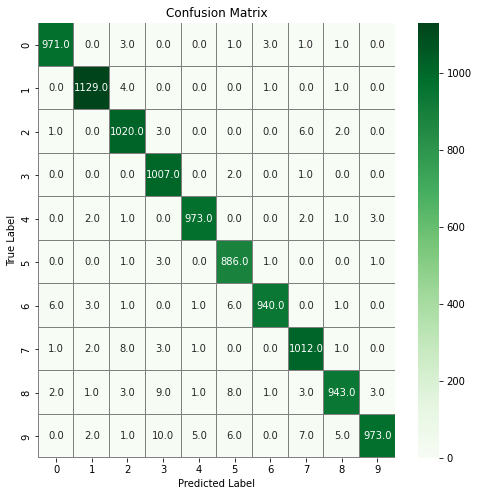

In [20]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
#the loss function
loss_fn = tf.keras.losses.MeanSquaredError(reduction='none')
loss_fn(tf.ones((2, 2,)), tf.zeros((2, 2)))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

In [22]:
#setting the callbacks and earlystop in the model
checkpoint_path= r"/n" #setting a local path in the collab
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_path,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
callbacks_list = [checkpoint]
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
model.fit(x_train, y_train,batch_size=batch_size, epochs=100, validation_split=0.2,callbacks=[earlystop,checkpoint])


Epoch 1/100
375/375 [==============================] - 4s 9ms/step - loss: 0.0950 - accuracy: 0.9710 - val_loss: 0.0409 - val_accuracy: 0.9879

Epoch 00001: val_loss improved from inf to 0.04092, saving model to /n
INFO:tensorflow:Assets written to: /n/assets
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0844 - accuracy: 0.9738 - val_loss: 0.0351 - val_accuracy: 0.9897

Epoch 00002: val_loss improved from 0.04092 to 0.03512, saving model to /n
INFO:tensorflow:Assets written to: /n/assets
Epoch 3/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0782 - accuracy: 0.9754 - val_loss: 0.0365 - val_accuracy: 0.9891

Epoch 00003: val_loss did not improve from 0.03512
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0747 - accuracy: 0.9762 - val_loss: 0.0358 - val_accuracy: 0.9894

Epoch 00004: val_loss did not improve from 0.03512
Epoch 5/100
375/375 [==============================] - 3s 9ms/step - loss: 0.0725 - ac

In [23]:
#printing the latest test and train accuracy
train_acc=model.evaluate(x_train, y_train,verbose=0)
test_acc=model.evaluate(x_test, y_test,verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc[1]*100, test_acc[1]*100))

Train Accuracy: 99.343, Test Accuracy: 98.990


Compiling losses, using various optimizers

In [27]:
#using adagrad optimizer
adagrad = tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad")
model.compile(optimizer = adagrad , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 5, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
468/468 [==============================] - 27s 57ms/step - loss: 0.2365 - accuracy: 0.9282 - val_loss: 0.0270 - val_accuracy: 0.9903
Epoch 2/10
468/468 [==============================] - 27s 57ms/step - loss: 0.2220 - accuracy: 0.9315 - val_loss: 0.0270 - val_accuracy: 0.9903
Epoch 3/10
468/468 [==============================] - 27s 58ms/step - loss: 0.2142 - accuracy: 0.9348 - val_loss: 0.0269 - val_accuracy: 0.9903
Epoch 4/10
468/468 [==============================] - 27s 58ms/step - loss: 0.2082 - accuracy: 0.9359 - val_loss: 0.0268 - val_accuracy: 0.9906
Epoch 5/10
468/468 [==============================] - 27s 57ms/step - loss: 0.2052 - accuracy: 0.9371 - val_loss: 0.0268 - val_accuracy: 0.9906
Epoch 6/10
468/468 [==============================] - 26s 56ms/step - loss: 0.1995 - accuracy: 0.9399 - val_loss: 0.0266 - val_accuracy: 0.9910
Epoch 7/10
468/468 [==============================] - 27s 58ms/step - loss: 0.1940 - accuracy: 0.9411 - val_loss: 0.0266 - val_accuracy:

In [29]:
#using RMSprop optimizer
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,name='RMSprop') 
model.compile(optimizer = adagrad , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 5, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
468/468 [==============================] - 27s 57ms/step - loss: 0.1813 - accuracy: 0.9433 - val_loss: 0.0265 - val_accuracy: 0.9908
Epoch 2/5
468/468 [==============================] - 26s 56ms/step - loss: 0.1844 - accuracy: 0.9435 - val_loss: 0.0265 - val_accuracy: 0.9910
Epoch 3/5
468/468 [==============================] - 27s 57ms/step - loss: 0.1831 - accuracy: 0.9436 - val_loss: 0.0265 - val_accuracy: 0.9912
Epoch 4/5
468/468 [==============================] - 27s 57ms/step - loss: 0.1796 - accuracy: 0.9452 - val_loss: 0.0266 - val_accuracy: 0.9910
Epoch 5/5
468/468 [==============================] - 26s 56ms/step - loss: 0.1799 - accuracy: 0.9453 - val_loss: 0.0265 - val_accuracy: 0.9913


In [30]:
#using SGD optimizer
SGD=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0,nesterov=False, name="SGD")
model.compile(optimizer = adagrad , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 5, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
468/468 [==============================] - 27s 57ms/step - loss: 0.1775 - accuracy: 0.9458 - val_loss: 0.0265 - val_accuracy: 0.9913
Epoch 2/5
468/468 [==============================] - 27s 57ms/step - loss: 0.1765 - accuracy: 0.9470 - val_loss: 0.0265 - val_accuracy: 0.9913
Epoch 3/5
468/468 [==============================] - 26s 56ms/step - loss: 0.1738 - accuracy: 0.9470 - val_loss: 0.0266 - val_accuracy: 0.9912
Epoch 4/5
468/468 [==============================] - 27s 57ms/step - loss: 0.1716 - accuracy: 0.9461 - val_loss: 0.0266 - val_accuracy: 0.9914
Epoch 5/5
468/468 [==============================] - 26s 56ms/step - loss: 0.1739 - accuracy: 0.9460 - val_loss: 0.0266 - val_accuracy: 0.9914


In [31]:
class LearningRateDecay:
	def plot(self, epochs, title="Learning Rate Schedule"):
		# compute the set of learning rates for each corresponding
		# epoch
		lrs = [self(i) for i in epochs]
		# the learning rate schedule
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(epochs, lrs)
		plt.title(title)
		plt.xlabel("Epoch #")
		plt.ylabel("Learning Rate")

In [65]:
def my_learning_rate(epoch, lrate):
	return lrate
lrs = LearningRateScheduler(my_learning_rate)
history=model.fit(x_train, y_train,batch_size=batch_size, epochs=5, validation_split=0.2,callbacks=[earlystop,checkpoint,lrs])


Epoch 1/5
375/375 [==============================] - 3s 9ms/step - loss: 0.0489 - accuracy: 0.9844 - val_loss: 0.0297 - val_accuracy: 0.9906

Epoch 00001: val_loss improved from 0.02971 to 0.02970, saving model to /n
INFO:tensorflow:Assets written to: /n/assets
Epoch 2/5
375/375 [==============================] - 3s 9ms/step - loss: 0.0513 - accuracy: 0.9840 - val_loss: 0.0297 - val_accuracy: 0.9906

Epoch 00002: val_loss improved from 0.02970 to 0.02966, saving model to /n
INFO:tensorflow:Assets written to: /n/assets
Epoch 3/5
375/375 [==============================] - 3s 9ms/step - loss: 0.0475 - accuracy: 0.9851 - val_loss: 0.0297 - val_accuracy: 0.9906

Epoch 00003: val_loss improved from 0.02966 to 0.02966, saving model to /n
INFO:tensorflow:Assets written to: /n/assets
Epoch 4/5
375/375 [==============================] - 3s 8ms/step - loss: 0.0487 - accuracy: 0.9848 - val_loss: 0.0297 - val_accuracy: 0.9906

Epoch 00004: val_loss improved from 0.02966 to 0.02966, saving model to 

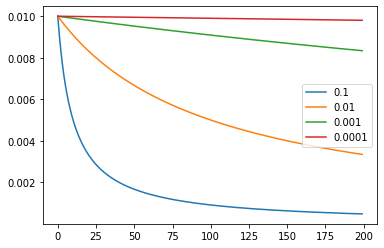

In [76]:

# learning rate decay
def decay_lrate(initial_lrate, decay, iteration):
	return initial_lrate * (1.0 / (1.0 + decay * iteration))
decays = [1E-1, 1E-2, 1E-3, 1E-4]
lrate = 0.01
n_updates = 200
for decay in decays:
	# calculate learning rates for updates
	lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
	# plot result
	plt.plot(lrates, label=str(decay))
plt.legend()
plt.show()
SGD=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0,nesterov=False, name="SGD")
model.compile(optimizer = adagrad , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 5, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

Learning rate

In [97]:
def exp_decay(epoch):
    lr = learningRate * np.exp(-decay_rate*epoch)
    return lrate
lr_rate = LearningRateScheduler(exp_decay)
checkpoint_path=r"\n"
checkpoint = ModelCheckpoint(checkpoint_path,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
model.fit(x_train, y_train,batch_size=batch_size, epochs=100, validation_split=0.2,callbacks=[earlystop,checkpoint,lr_rate])


Epoch 1/100
375/375 [==============================] - 4s 9ms/step - loss: 0.1760 - accuracy: 0.9464 - val_loss: 0.0614 - val_accuracy: 0.9816

Epoch 00001: val_loss improved from inf to 0.06138, saving model to \n
INFO:tensorflow:Assets written to: \n/assets
Epoch 2/100
375/375 [==============================] - 3s 9ms/step - loss: 0.1515 - accuracy: 0.9555 - val_loss: 0.0549 - val_accuracy: 0.9841

Epoch 00002: val_loss improved from 0.06138 to 0.05485, saving model to \n
INFO:tensorflow:Assets written to: \n/assets
Epoch 3/100
375/375 [==============================] - 3s 9ms/step - loss: 0.1483 - accuracy: 0.9573 - val_loss: 0.0502 - val_accuracy: 0.9847

Epoch 00003: val_loss improved from 0.05485 to 0.05023, saving model to \n
INFO:tensorflow:Assets written to: \n/assets
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 0.1383 - accuracy: 0.9580 - val_loss: 0.0534 - val_accuracy: 0.9853

Epoch 00004: val_loss did not improve from 0.05023
Epoch 5/100
375/3

NameError: ignored

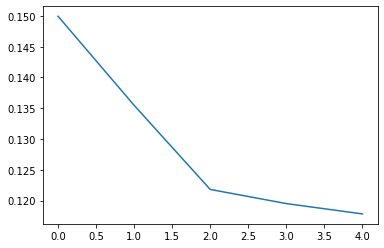

In [116]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(lr, label='Learning Rate')
plt.title('lrate='+str(lrate), pad=-50)